122835.09300652589
122835.09309395924
122835.445809403
31841.91913097528
31841.696625205113
31841.919130291048
102883.60665598139
102883.60665384741
102883.32979358056
103949.91315299307
103949.91309255645
103949.60173724906
31743.457696081467
31629.665975253014
31743.457675880338
103328.38783042523
103328.43813251275
103328.07950467826
98322.0267328544
98360.8672740789
98321.74798866958
24831.965468464696
19800.769219864218
24831.964871482523
85654.35273464167
86028.33699455361
85654.13962059544
48750.95119701902
52196.52735935133
48750.8645854105
16017.421228097637
17425.971922092394
16017.41354506144
18030.35782140674
15457.806580726789
18030.353400947817
16017.421228097637
17425.971922092394
16017.41354506144
31841.918759890224
31841.695839473363
31841.91875920537
26639.250393815637
22397.51151330187
26639.25018473357
16631.513507929543
16718.688706571455
16631.50717488664
16040.54526845476
17397.214129952645
16040.537647117939
16018.311013521534
17424.86164190824
16018.30333288007

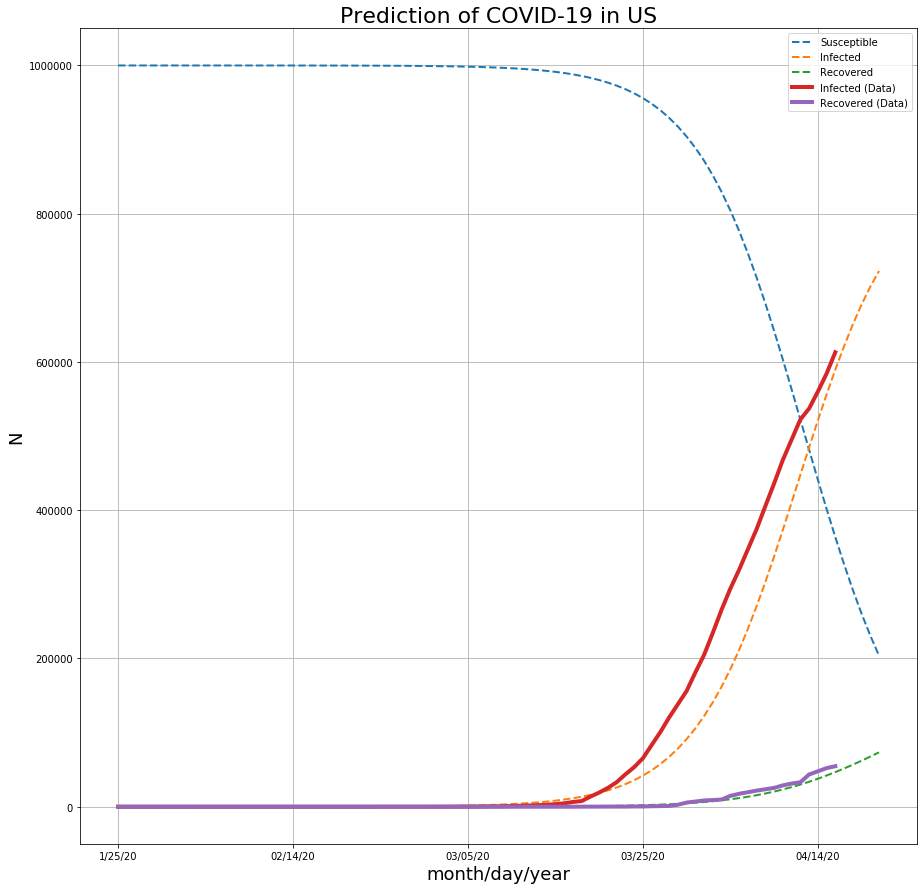

1/25/20         12.000000
01/26/20        12.380347
01/27/20        12.829713
01/28/20        13.360827
01/29/20        13.987810
                ...      
04/17/20    672780.428376
04/18/20    707254.969532
04/19/20    739444.372659
04/20/20    769122.813465
04/21/20    796158.586174
Length: 88, dtype: float64


In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

# Predict function
def predict(x, infected_data, recovered_data, init, beta, gamma, start, country):
    
    # ODE Function
    def sir(t, y):
            
        # Outputs
        S = y[0]
        I = y[1]
        R = y[2]
        
        return [-beta*I*S, beta*I*S - gamma*I, gamma*I]
    
    # Extending N days after now
    t_extend = len(x) +5 # N days
    t = np.linspace(0, t_extend, t_extend) #0 + number of dates in data + extended date 
    
    # Solving SIR : [solver_ivp] - Solve an initial value problem for a system of ODEs.
    res = solve_ivp(sir, 
                    [0, t_extend], 
                    [init[0], init[1], init[2]],
                    t_eval=np.arange(0,t_extend,1))
    
    # Preparing date axis
    date_format = '%m/%d/%y'
    time = start
    for i in range(t_extend-1):
        time_add = datetime.strptime(start, date_format) + timedelta(days=i+1)
        time = np.append(time, time_add.strftime(date_format))
    
    # Adding NaN values of to official data for plotting
    infected_data = np.concatenate((infected_data, [None] * (t_extend-len(infected_data))))
    recovered_data = np.concatenate((recovered_data, [None] * (t_extend-len(recovered_data))))
    
    # Plotting
    df = pd.DataFrame({'Susceptible': res.y[0], 
                        'Infected': res.y[1], 
                        'Recovered': res.y[2], 
                        "Infected (Data)": infected_data, 
                        "Recovered (Data)": recovered_data}, 
                        index=time)
    fig, ax = plt.subplots(figsize = (15,15))
    df['Susceptible'].plot(linestyle = '--', linewidth = 2)
    df['Infected'].plot(linestyle = '--', linewidth = 2)
    df['Recovered'].plot(linestyle = '--', linewidth = 2)
    df['Infected (Data)'].plot(linewidth = 4)
    df['Recovered (Data)'].plot(linewidth = 4)
    plt.ylabel("N", fontsize=18)
    plt.xlabel("month/day/year", fontsize=18)
    plot_title = ('Prediction of COVID-19 in ' + country)
    plt.title(plot_title, fontsize=22)
    plt.legend()
    plt.grid()
    plt.show()
    print(df['Infected']+df['Recovered'])
    

# Cost function for fitting
def cost(point, infected_data, recovered_data, init):
    
    beta, gamma = point
    
    # ODE Function
    def sir(t, y):
            
        # Outputs
        S = y[0]
        I = y[1]
        R = y[2]   
        return [-beta*I*S, beta*I*S - gamma*I, gamma*I]
   
    # Solving SIR : [solver_ivp] - Solve an initial value problem for a system of ODEs.
    res = solve_ivp(sir, 
                    [0, len(infected_data)], 
                    [init[0], init[1], init[2]],
                    t_eval=np.arange(0,len(infected_data),1))
  
    # Returns RMSE (Root Mean Square Error) for the function
    rmse_infect = np.sqrt(np.mean((res.y[1] - infected_data)**2)) 
    rmse_recoverd = np.sqrt(np.mean((res.y[2] - recovered_data)**2)) 
    
    # Defining weights
    alpha = 0.1
    print(alpha*rmse_infect + (1-alpha)*rmse_recoverd)
    return alpha*rmse_infect + (1-alpha)*rmse_recoverd

plt.close()
c_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
r_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

country = "US" # input country here
start_date = "1/25/20" # input starting date here

# Parsing confirmed/recovered cases from csv
confirmed = c_df[c_df['Country/Region'] == country].iloc[0].loc[start_date:]
recovered = r_df[r_df['Country/Region'] == country].iloc[0].loc[start_date:]

# Truncate last element to fit recovered data
confirmed = confirmed.values 
recovered = recovered.values

# I(t)
infect = confirmed - recovered

# Suceptable
N = 500000*2 #current number of infected * 2.0~ 2.5(R0, Reproductive number of COVID-19)
# Number of infected at t0
I0 = 2
S0 = N-I0
R0 = 10

# S(t) = N - I(t) - R(t)
S = N - confirmed

# Parameters to optimize

#Keep working on boundaries.
optimal = minimize(cost, [0.001, 0.001], args=(infect, recovered, [S0, I0, R0]), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])

# Prints Beta/Gamma
print(optimal.x)

# Prints Gamma/Beta, if S0 > Gamma/Beta -> exponential growth
print("Gamma/Beta: " + str(optimal.x[1]/optimal.x[0]))

# Prints Repoductive Ratio S0*Beta/Gamma.
print("S0*Beta/Gamma: " + str(S0*optimal.x[0]/optimal.x[1]))
print("S0 : " +str(S0))

# Predicting numbers from optimized gamma & beta
t = np.linspace(0,len(infect), len(infect))
predict(np.transpose(t), infect, recovered, [S0, I0, R0], optimal.x[0], optimal.x[1], start_date, country)